In [11]:
# -*- coding: utf-8 -*-
import pandas as pd
from datetime import datetime, timedelta
import pytz

import sys
sys.path.append("../")

# 统一后的 V2 接口（与 V1 兼容）
from utils.RollingLoadratePrice_utils_V2 import (
    RollingLoadratePriceForecaster,                  # >>> 新统一类名
    build_curves_record_with_history_from_csv,       # >>> 新统一一键构建
    plot_static_curves_unified,
    plot_price_timeseries_unified,
    process_market_data,
)

# ---- 1) 日期与数据读取 ----
beijing_tz = pytz.timezone("Asia/Shanghai")
tomorrow = datetime.now().astimezone(beijing_tz) + timedelta(days=1)
dstr = tomorrow.strftime("%Y-%m-%d")
print(f"推理日期: {dstr}")

market_data = pd.read_parquet("../data/processed/shanxi_new.parquet", engine="fastparquet")
# 与 V1 一致的预处理：会生成“日前竞价空间/实时竞价空间/日前价格”等统一列名
market_data = process_market_data(market_data, date_begin="2025-01-01", date_end=dstr)

# 先做一个快速检查：推理日有没有“日前竞价空间/日前价格”
try:
    probe = market_data.loc[dstr, ["日前竞价空间", "日前价格"]]
    print("【检查】推理日行数 =", len(probe))
except KeyError:
    print("【错误】推理日没有任何‘日前竞价空间/日前价格’的行，无法进行推理。")
    print("       请确认 parquet 是否包含明天(日前)计划数据，或推迟到数据齐全后再跑。")
    raise SystemExit(1)

# ---- 2) 构建 curves_record（推理：竞价空间→价格） ----
curves_inf = build_curves_record_with_history_from_csv(
    market_data=market_data,
    date_begin=dstr,                          # 推理日
    date_end=dstr,
    d=7,                                      # 前 d 天历史窗口
    pattern="inference",                      # >>> 推理模式
    x_mode="bidspace",                        # >>> 使用“竞价空间→价格”
    selection="match",                        # 与 V1 相同四选一
    # 图1：预测 CSV（当天必须有 Pred_Label）
    pred_csv_path=rf"../save/today_pred/today_pred_hiking_V2_{dstr}.csv",
    pred_date_col="Date",
    pred_label_col="Pred_Label",
    # 图2：真实标签 CSV（用于从更长历史里筛同类日）
    truth_csv_path="../data/processed/hiking_01_dataset.csv",
    truth_date_col="date",
    truth_da_col="da_hiking",
    truth_rt_col="rt_hiking",
    # 分箱/插值参数（竞价空间建议等频分箱）
    bin_method="quantile",
    n_bins=30,
    fixed_bin_width=None,
    grid_step=None,
)


推理日期: 2025-08-21
Index(['price', '实时价格', '实时在线机组容量(MW)', '实时负荷率(%)', '非市场化机组出力-日内(MW)',
       '联络线计划-日内(MW)', '竞价空间-日内(MW)', '频率实际值(MW)', '实际上旋备用(MW)', '实际下旋备用(MW)',
       '省调负荷-日内(MW)', '新能源负荷-日内(MW)', '实时风电(MW)', '实时光伏(MW)', '水电出力值-日内(MW)',
       '日前在线机组容量(MW)', '日前负荷率(%)', '非市场化机组出力-日前(MW)', '联络线计划-日前(MW)',
       '竞价空间-日前(MW)', '省调负荷-日前(MW)', '新能源负荷-日前(MW)', '正备用-日前(MW)',
       '新能源负荷备用-日前(MW)', '日前光伏(MW)', '日前风电(MW)'],
      dtype='object')
【检查】推理日行数 = 96


【结果】curves_record 条目数 = 1
【诊断】DA 历史使用天数 = 7 ；RT 历史使用天数 = 7 ；Pred_Label = 1


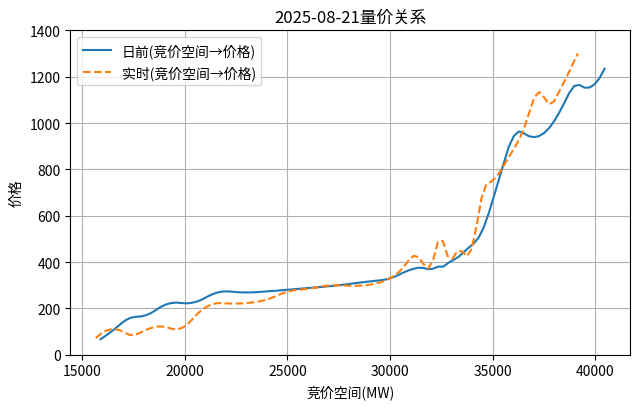

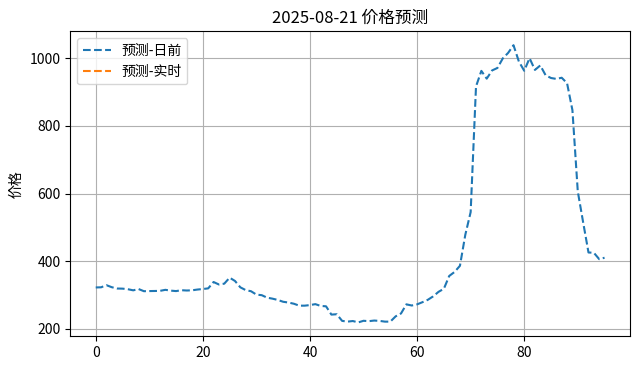

In [12]:
print("【结果】curves_record 条目数 =", len(curves_inf))
if not curves_inf:
    print("【提示】本次没有生成任何记录，常见原因：")
    print("  1) 推理日缺少‘日前竞价空间’行（最常见）；")
    print("  2) selection='match' 但当天预测CSV缺失该日；")
    print("  3) 历史筛选后样本为 0；")
else:
    # 打印当日的诊断信息
    info = curves_inf[dstr]
    print("【诊断】DA 历史使用天数 =", len(info.get("history_dates_used_da", [])),
          "；RT 历史使用天数 =", len(info.get("history_dates_used_rt", [])),
          "；Pred_Label =", info.get("hiking_pred", None))

# ---- 3) 可视化（空结果会自动跳过） ----
if curves_inf:
    plot_static_curves_unified(curves_inf, pattern="inference", x_mode="bidspace")
    plot_price_timeseries_unified(curves_inf, pattern="inference")

In [14]:
curves_inf[tomorrow.strftime("%Y-%m-%d")]['bidspace_price_curve_interpolate_da'].to_csv(rf'../save/today_pred/bidspace_curve_da_{dstr}.csv')
curves_inf[tomorrow.strftime("%Y-%m-%d")]['bidspace_price_curve_interpolate_rt'].to_csv(rf'../save/today_pred/bidspace_curve_rt_{dstr}.csv')
curves_inf[tomorrow.strftime("%Y-%m-%d")]['price_pred_da'].to_csv(rf'../save/today_pred/price_pred_da_{dstr}.csv')
print(f"已保存预测结果到：../save/today_pred 文件夹中")

已保存预测结果到：../save/today_pred 文件夹中
